read about perlin noise for initial landscape
https://en.wikipedia.org/wiki/Perlin_noise

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib notebook
import matplotlib as mpl
import scipy.signal as signal
import numba
from numba import jit
import popdyn
import popdyn.convolve as cv
import copy
from importlib import reload
import matplotlib.animation as animation
from IPython.display import HTML


plt.rcParams["animation.html"] = "jshtml"

In [3]:
tmap = np.zeros((10, 10))
tmap[5, 5] = 10

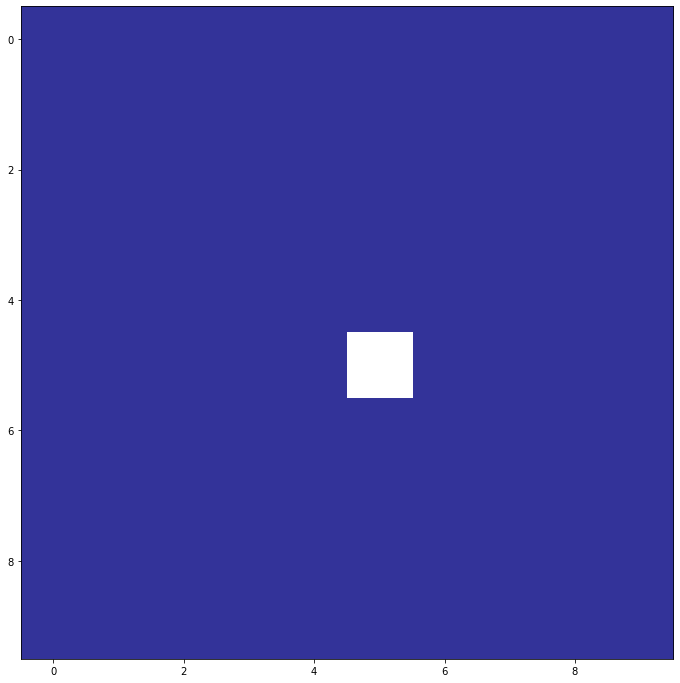

In [4]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.imshow(tmap, cmap=plt.cm.terrain)
fig.savefig("map.png")

In [5]:
def calc_shifted(inmap):
    """shift up, down, left, right"""

    omap = []
    tmp = np.roll(inmap, -1, axis=0)
    tmp[-1:, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap, 1, axis=0)
    tmp[:1, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap, -1, axis=1)
    tmp[:, -1:] = 0
    omap.append(tmp)        

    tmp = np.roll(inmap, 1, axis=1)
    tmp[:, :1] = 0
    omap.append(tmp)     
    return np.array(omap)   

def calc_unshifted(inmap):
    omap = []

    tmp = np.roll(inmap[0, :, :], 1, axis=0)
    tmp[:1, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap[1, :, :], -1, axis=0)
    tmp[-1:, :] = 0
    omap.append(tmp)

    tmp = np.roll(inmap[2, :, :], 1, axis=1)
    tmp[:, :1] = 0
    omap.append(tmp)     

    tmp = np.roll(inmap[3, :, :], -1, axis=1)
    tmp[:, -1:] = 0
    omap.append(tmp)        

    return np.array(omap)

def center_cut(arr):
    return arr[1:-1, 1:-1]

class CellStepNaive(object):
    def __init__(self, canvas):
        self.canvas = copy.deepcopy(canvas)
        self.canvas_padded = np.pad(canvas, pad_width=1, mode="edge")

    
        self.imap = np.arange(len(self.canvas.flatten())).reshape(self.canvas.shape)
        self.imap_padded = np.arange(len(self.canvas_padded.flatten())).reshape(self.canvas_padded.shape)
        self.imap_center = center_cut(self.imap_padded)
        self.imap_shifted = [center_cut(tmp) for tmp in calc_shifted(self.imap_padded)]
        self.imap_unshifted = [
            self.imap_shifted[1],
            self.imap_shifted[0],
            self.imap_shifted[3],
            self.imap_shifted[2],
        ]
        
    
    def step(self):
        """
        Water flows downhill into the ocean, from each point on and on
        
        
        This is the from out to in phylosophy, where water flow is calculated from other to here for each cell
        
        This is equivalent to the in to out phylosophy, just easier to implement vectorized
        """
        
        self.height_local = self.canvas
        self.height_shifted = np.array([self.canvas_padded.flat[ii] for ii in self.imap_shifted])
#         print(self.canvas)
        self.diffs = (self.height_local - self.height_shifted) # how much higher the neighbor cell is than this
        self.diffs[self.diffs < 0] = 0
        fractions = np.nan_to_num(self.diffs / self.diffs.sum(axis=0))
        landslide = self.diffs.sum(axis=0) * fractions *0.2# this is how much matter leaves this cell in each direction
#         print(landslide)
        self.height_local -= landslide.sum(axis=0)
        self.landslide = []
        for i, ii in enumerate(self.imap_unshifted):
            tmp = np.pad(landslide[i], pad_width=1, mode="constant", constant_values=0)
            tmp = tmp.flat[ii]
            self.landslide.append(tmp)
        self.landslide = np.array(self.landslide)
        self.height_local += self.landslide.sum(axis=0)
        
        self.canvas = self.height_local
        self.canvas_padded = np.pad(self.canvas, pad_width=1, mode="edge")
#         print(self.canvas.sum())

    def flow(self, nstep=100):
        self.maps = []
        self.maps.append(self.canvas.copy())
        for i in np.arange(nstep):
            print(str(i) + ' out of ' + str(nstep-1), end="\r")
            self.step()
            self.maps.append(self.canvas.copy())

In [196]:
cs = CellStepNaive(tmap)
cs.flow(1)

/tmp/ipykernel_3947/2275101129.py:79: RuntimeWarning: invalid value encountered in true_divide
  fractions = np.nan_to_num(self.diffs / self.diffs.sum(axis=0))


In [197]:
maps = cs.maps

In [199]:
maps

[array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 0., 0., 2., 2., 2., 0., 0., 0.],
        [0., 0., 0., 0., 0., 2., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]

In [198]:
maps[3].sum()

IndexError: list index out of range

# A generalized cell automata with optimized calculation

In [201]:
def pad(canvases):

    keys = canvases.keys()
    padded_canvases = {}
    for key in keys:
        arr = canvases[key]
        arr = np.pad(arr, pad_width=1, mode="edge")
        padded_canvases.update({key: arr})
    return padded_canvases

class CellSpace(object):
    def __init__(self, initial_maps, rules):
        
        self.canvases = copy.deepcopy(initial_maps)
        self.layers = list(initial_maps.keys())
        self.padded_canvases = pad(self.canvases)

        self.shape_canvas = self.canvases[self.layers[0]].shape
        self.shape_canvas_padded = self.padded_canvases[self.layers[0]].shape
    
        self.imap = np.arange(len(self.canvases[self.layers[0]].flatten())).reshape(self.shape_canvas)
        self.imap_padded = np.arange(len(self.padded_canvases[self.layers[0]].flatten())).reshape(self.shape_canvas_padded)
        self.imap_center = center_cut(self.imap_padded)
        self.imap_shifted = [center_cut(tmp) for tmp in calc_shifted(self.imap_padded)]
        self.imap_unshifted = [
            self.imap_shifted[1],
            self.imap_shifted[0],
            self.imap_shifted[3],
            self.imap_shifted[2],
        ]
        
        self.shifted_canvases = self.shift()
        self.rules = rules
        
        self.maps = {}
        self.reset_maps()
            
    def update_maps(self):
        for key in self.layers:
            self.maps[key].append(self.canvases[key])
            
    def reset_maps(self):
        self.maps = {}
        for key in self.layers:
            dd = {key: [self.canvases[key],]}
            self.maps.update(dd)            
       
    def shift(self):
        shifted_canvases = {}
        for key in self.canvases.keys():
            arr = np.array([self.padded_canvases[key].flat[ii] for ii in self.imap_shifted])
            shifted_canvases.update({key: arr})
        return shifted_canvases
            
            
    def step(self):
        
        new_canvases = {}
        for key in self.layers:
            rl = self.rules[key]
            canvas = rl.evolve(self)
            new_canvases.update(canvas)
            
        self.canvases = new_canvases
        self.padded_canvases = pad(self.canvases)
        self.shifted_canvases = self.shift()


    def flow(self, nstep=100):
        self.reset_maps()
        for i in np.arange(nstep):
            print(str(i) + ' out of ' + str(nstep-1), end="\r")
            self.step()
            self.update_maps()

In [224]:
class Landslide(object):
    def __init__(self, erosion_factor=1):
        self.key = "terrain"
        self.erosion_factor = erosion_factor
    
    def evolve(self, cell):
        height_local = cell.canvases[self.key]
        height_shifted = cell.shifted_canvases[self.key]
        
        diffs = height_local - height_shifted
        diffs[diffs < 0] = 0
#         print(diffs)
        
        fractions = np.nan_to_num(diffs / diffs.sum(axis=0))
#         print(fractions)
        landslide = diffs.sum(axis=0) * fractions * self.erosion_factor # this is the outgoing amount
        
        
        height_local -= landslide.sum(axis=0)
        shifted_landslide = [] 
        for i, ii in enumerate(cell.imap_unshifted):
            tmp = np.pad(landslide[i], pad_width=1, mode="constant", constant_values=0)
            tmp = tmp.flat[ii]
            shifted_landslide.append(tmp)
        shifted_landslide = np.array(shifted_landslide)
        height_local += shifted_landslide.sum(axis=0)        
        
        resdict = {self.key: height_local}
        return resdict
        
    

In [225]:
tmap = np.zeros((10, 10))
tmap[5, 5] = 10

initial_maps = {
    "terrain": tmap,
}
rules = {
    "terrain": Landslide(),
}
key = "terrain"

In [226]:
cs = CellSpace(initial_maps, rules)

In [227]:
cs.step()

/tmp/ipykernel_3947/1686092357.py:14: RuntimeWarning: invalid value encountered in true_divide
  fractions = np.nan_to_num(diffs / diffs.sum(axis=0))


In [228]:
cs.canvases

{'terrain': array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,  10.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,  10., -30.,  10.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,  10.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]])}

In [173]:
cs.flow(100)

/tmp/ipykernel_3947/1754892680.py:13: RuntimeWarning: invalid value encountered in true_divide
  fractions = np.nan_to_num(diffs / diffs.sum(axis=0))


In [176]:
cs.canvases

{'terrain': array([[-4.32358573e+146,  1.21244332e+147, -1.66661357e+147,
          2.26797280e+147, -2.28167699e+147,  2.49987108e+147,
         -2.07083053e+147,  1.82664171e+147, -1.10699201e+147,
          5.59408642e+146],
        [ 1.21244332e+147, -2.73189402e+147,  3.90127406e+147,
         -5.09351299e+147,  5.33770560e+147, -5.61381981e+147,
          4.84485664e+147, -4.10452112e+147,  2.59996732e+147,
         -1.10707568e+147],
        [-1.66661357e+147,  3.90127406e+147, -6.15675296e+147,
          7.26522186e+147, -8.42161768e+147,  8.00679368e+147,
         -7.64455967e+147,  5.85554190e+147, -4.10503984e+147,
          1.82698586e+147],
        [ 2.26797280e+147, -5.09351299e+147,  7.26522186e+147,
         -9.48551234e+147,  9.93663952e+147, -1.04535713e+148,
          9.01990790e+147, -7.64584241e+147,  4.84617738e+147,
         -2.07160584e+147],
        [-2.28167699e+147,  5.33770560e+147, -8.42161768e+147,
          9.93663952e+147, -1.15179501e+148,  1.09504504e+

In [175]:
cs.maps[key]

[array([[-4.32358573e+146,  1.21244332e+147, -1.66661357e+147,
          2.26797280e+147, -2.28167699e+147,  2.49987108e+147,
         -2.07083053e+147,  1.82664171e+147, -1.10699201e+147,
          5.59408642e+146],
        [ 1.21244332e+147, -2.73189402e+147,  3.90127406e+147,
         -5.09351299e+147,  5.33770560e+147, -5.61381981e+147,
          4.84485664e+147, -4.10452112e+147,  2.59996732e+147,
         -1.10707568e+147],
        [-1.66661357e+147,  3.90127406e+147, -6.15675296e+147,
          7.26522186e+147, -8.42161768e+147,  8.00679368e+147,
         -7.64455967e+147,  5.85554190e+147, -4.10503984e+147,
          1.82698586e+147],
        [ 2.26797280e+147, -5.09351299e+147,  7.26522186e+147,
         -9.48551234e+147,  9.93663952e+147, -1.04535713e+148,
          9.01990790e+147, -7.64584241e+147,  4.84617738e+147,
         -2.07160584e+147],
        [-2.28167699e+147,  5.33770560e+147, -8.42161768e+147,
          9.93663952e+147, -1.15179501e+148,  1.09504504e+148,
      